# A deep learning approach identifies new ECG features in congenital long QT syndrome.

Aufiero, S.; Bleijendaal, H.; Robyns, T.; Vandenberk, B.; Krijger, C.; Bezzina, C.; Zwinderman, A.H.; Wilde, A.A.M.; Pinto, Y.M. ***A deep learning approach identifies new ECG features in congenital long QT syndrome***. *BMC Med*. 2022 

### Introduction
This study presents 1D convolutional neural network models trained to identify genotype positive LQTS patients from electrocardiogram as input. The deep learning (DL) models were trained with a large 10-s 12-lead ECGs dataset
### Using the code in coursework
This code was used for the course work of Artem Vlasov's student of group 23 CST 2 'Classification of arrhythmias by ECG based on in-depth learning'.
### Data and code availability
The 12-lead ECG data set used in this study is the CPSC2018 training dataset which is released by the first China Physiological Signal Challenge (CPSC) 2018 during the seventh International Conference on Biomedical Engineering and Biotechnology. Details of the CPSC2018 dataset can be found at http://2018.icbeb.org/Challenge.html. The source code is provided and is available at https://github.com/Aufiero/aiecglqts.

In [2]:
# Model
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Conv1D, Flatten, LeakyReLU, BatchNormalization, MaxPooling1D
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from keras.layers import Input

from tensorflow.keras.layers import (Input, Conv1D, BatchNormalization, LeakyReLU,
                                     Add, MaxPooling1D, Dropout, GlobalAveragePooling1D, Dense)

# Load libraries
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
from scipy.special import softmax

2025-04-17 11:32:52.204285: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744889572.407933      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744889572.471378      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
import os
from glob import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import wfdb
from tqdm import tqdm
from biosppy import ecg, tools
import scipy

import warnings
import pywt

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix

Due to the lack of publicly available code for dataset preprocessing, the functions for data preprocessing were taken from the SHAP-based model.

In [ ]:
def cal_entropy(coeff):
    coeff = pd.Series(coeff).value_counts()
    entropy = scipy.stats.entropy(coeff)
    return entropy / 10


def cal_statistics(signal):
    n5 = np.percentile(signal, 5)
    n25 = np.percentile(signal, 25)
    n75 = np.percentile(signal, 75)
    n95 = np.percentile(signal, 95)
    median = np.percentile(signal, 50)
    mean = np.mean(signal)
    std = np.std(signal)
    var = np.var(signal)
    return [n5, n25, n75, n95, median, mean, std, var]


def extract_lead_heart_rate(signal, sampling_rate):
    # extract heart rate for single-lead ECG: may return empty list
    rpeaks, = ecg.hamilton_segmenter(signal=signal, sampling_rate=sampling_rate)
    rpeaks, = ecg.correct_rpeaks(signal=signal, rpeaks=rpeaks, sampling_rate=sampling_rate, tol=0.05)
    _, heartrates = tools.get_heart_rate(beats=rpeaks, sampling_rate=500, smooth=True, size=3)
    return list(heartrates / 100) # divided by 100


def extract_heart_rates(ecg_data, sampling_rate=500):
    # extract heart rates using 12-lead since rpeaks can not be detected on some leads
    heartrates = []
    for signal in ecg_data.T:
        lead_heartrates = extract_lead_heart_rate(signal=signal, sampling_rate=sampling_rate)
        heartrates += lead_heartrates
    return cal_statistics(heartrates)


def extract_lead_features(signal):
    # extract expert features for single-lead ECGs: statistics, shannon entropy
    lead_features = cal_statistics(signal) # statistic of signal
    coeffs = pywt.wavedec(signal, 'db10', level=4)
    for coeff in coeffs:
        lead_features.append(cal_entropy(coeff)) # shannon entropy of coefficients
        lead_features += cal_statistics(coeff) # statistics of coefficients
    return lead_features


def extract_features(ecg_data, sampling_rate=500):
    # extract expert features for 12-lead ECGs
    # may include heart rates later
    all_features = []
    for signal in ecg_data.T:
        all_features += extract_lead_features(signal)
    return all_features

In [ ]:
def split_data(seed=42):
    folds = range(1, 11)
    folds = np.random.RandomState(seed).permutation(folds)
    return folds[:8], folds[8:9], folds[9:]


def prepare_input(ecg_file: str, leads_idx=None, target_length=2500):
    if ecg_file.endswith('.mat'):
        ecg_file = ecg_file[:-4]
    
    ecg_data, _ = wfdb.rdsamp(ecg_file)  # (timesteps, leads)
    if leads_idx is not None:
        ecg_data = ecg_data[:, leads_idx]
    
    nsteps, nleads = ecg_data.shape
    ecg_data = ecg_data[-target_length:, :] 
    result = np.zeros((target_length, nleads))
    result[-nsteps:, :] = ecg_data
    
    return result


def cal_scores(y_true, y_pred, y_score):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_score)
    acc = accuracy_score(y_true, y_pred)
    return precision, recall, f1, auc, acc


def find_optimal_threshold(y_true, y_score):
    thresholds = np.linspace(0, 1, 100)
    f1s = [f1_score(y_true, y_score > threshold) for threshold in thresholds]
    return thresholds[np.argmax(f1s)]


def cal_f1(y_true, y_score, find_optimal):
    if find_optimal:
        thresholds = np.linspace(0, 1, 100)
    else:
        thresholds = [0.5]
    f1s = [f1_score(y_true, y_score > threshold) for threshold in thresholds]
    return np.max(f1s)


def cal_f1s(y_trues, y_scores, find_optimal=True):
    f1s = []
    for i in range(y_trues.shape[1]):
        f1 = cal_f1(y_trues[:, i], y_scores[:, i], find_optimal)
        f1s.append(f1)
    return np.array(f1s)


def cal_aucs(y_trues, y_scores):
    return roc_auc_score(y_trues, y_scores, average=None)

In [9]:
def gen_reference_csv(data_dir, reference_csv):
    if not os.path.exists(reference_csv):
        recordpaths = glob(os.path.join(data_dir, '*.hea'))
        results = []
        for recordpath in recordpaths:
            patient_id = recordpath.split('/')[-1][:-4]
            _, meta_data = wfdb.rdsamp(recordpath[:-4])
            sample_rate = meta_data['fs']
            signal_len = meta_data['sig_len']
            age = meta_data['comments'][0]
            sex = meta_data['comments'][1]
            dx = meta_data['comments'][2]
            age = age[5:] if age.startswith('Age: ') else np.NaN
            sex = sex[5:] if sex.startswith('Sex: ') else 'Unknown'
            dx = dx[4:] if dx.startswith('Dx: ') else ''
            results.append([patient_id, sample_rate, signal_len, age, sex, dx])
        df = pd.DataFrame(data=results, columns=['patient_id', 'sample_rate', 'signal_len', 'age', 'sex', 'dx'])
        df.sort_values('patient_id').to_csv(reference_csv, index=None)


def gen_label_csv(label_csv, reference_csv, dx_dict, classes):
    if not os.path.exists(label_csv):
        results = []
        df_reference = pd.read_csv(reference_csv)
        for _, row in df_reference.iterrows():
            patient_id = row['patient_id']
            dxs = [dx_dict.get(code, '') for code in row['dx'].split(',')]
            labels = [0] * 9
            for idx, label in enumerate(classes):
                if label in dxs:
                    labels[idx] = 1
            results.append([patient_id] + labels)
        df = pd.DataFrame(data=results, columns=['patient_id'] + classes)
        n = len(df)
        folds = np.zeros(n, dtype=np.int8)
        for i in range(10):
            start = int(n * i / 10)
            end = int(n * (i + 1) / 10)
            folds[start:end] = i + 1
        df['fold'] = np.random.permutation(folds)
        columns = df.columns
        df['keep'] = df[classes].sum(axis=1)
        df = df[df['keep'] > 0]
        df[columns].to_csv(label_csv, index=None)

In [10]:
if __name__ == "__main__":
    leads = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
    dx_dict = {
        '426783006': 'SNR', # Normal sinus rhythm
        '164889003': 'AF', # Atrial fibrillation
        '270492004': 'IAVB', # First-degree atrioventricular block
        '164909002': 'LBBB', # Left bundle branch block
        '713427006': 'RBBB', # Complete right bundle branch block
        '59118001': 'RBBB', # Right bundle branch block
        '284470004': 'PAC', # Premature atrial contraction
        '63593006': 'PAC', # Supraventricular premature beats
        '164884008': 'PVC', # Ventricular ectopics
        '429622005': 'STD', # ST-segment depression
        '164931005': 'STE', # ST-segment elevation
    }
    classes = ['SNR', 'AF', 'IAVB', 'LBBB', 'RBBB', 'PAC', 'PVC', 'STD', 'STE']
    data_dir = "/kaggle/input/dataset-map/CPSC"
    output_dir = '/kaggle/working/'
    reference_csv = os.path.join(output_dir, 'reference.csv')
    label_csv = os.path.join(output_dir, 'labels.csv')
    gen_reference_csv(data_dir, reference_csv)
    gen_label_csv(label_csv, reference_csv, dx_dict, classes)

In [11]:
warnings.filterwarnings('ignore', category=FutureWarning)

def generate_features_csv(features_csv, data_dir, patient_ids):
    print('Generating expert features...')
    ecg_features = []
    for patient_id in tqdm(patient_ids):
        ecg_data, _ = wfdb.rdsamp(os.path.join(data_dir, patient_id))
        ecg_features.append(extract_features(ecg_data))
    df = pd.DataFrame(ecg_features, index=patient_ids)
    df.index.name = 'patient_id'
    df.to_csv(features_csv)
    return df

In [ ]:
def prepare_data(patient_ids, folds, data_dir, target_length=2500):
    X = []
    for patient_id in patient_ids:
        if df_labels[df_labels['patient_id'] == patient_id]['fold'].iloc[0] in folds:
            ecg_file = os.path.join(data_dir, patient_id)
            ecg_data = prepare_input(ecg_file, leads_idx=None, target_length=target_length)
            X.append(ecg_data)
    return np.array(X)  # (n_samples, 2500, 12)

In [56]:
if __name__ == "__main__":
    classes = ['SNR', 'AF', 'IAVB', 'LBBB', 'RBBB', 'PAC', 'PVC', 'STD', 'STE']
    data_dir = "/kaggle/input/dataset-map/CPSC"
    output_dir = '/kaggle/working/'
    features_csv = os.path.join(output_dir, 'features.csv')
    labels_csv = os.path.join(output_dir, 'labels.csv')

    df_labels = pd.read_csv(labels_csv)
    patient_ids = df_labels['patient_id'].tolist()
    if not os.path.exists(features_csv):
        df_X = generate_features_csv(features_csv, data_dir, patient_ids)
    else:
        df_X = pd.read_csv(features_csv)
    df_X = df_X.merge(df_labels[['patient_id', 'fold']], on='patient_id')

    train_folds, val_folds, test_folds = split_data(seed=42)
    feature_cols = df_X.columns[1:-1] # remove patient id and fold

    # Подготовка данных
    X_train = prepare_data(patient_ids, train_folds, data_dir)
    X_val = prepare_data(patient_ids, val_folds, data_dir)
    X_test = prepare_data(patient_ids, test_folds, data_dir)

    y_train = df_labels[df_labels['fold'].isin(train_folds)][classes].to_numpy()
    y_val = df_labels[df_labels['fold'].isin(val_folds)][classes].to_numpy()
    y_test = df_labels[df_labels['fold'].isin(test_folds)][classes].to_numpy()

    print("Done")

Done


# CNN 

In [19]:
def get1DCNN(xTrain, nClasses, loss, activationDense):
    nTimesteps, nFeatures = xTrain.shape[1], xTrain.shape[2]
    inputs = Input(shape=(nTimesteps, nFeatures))

    x = inputs
    for i in range(3):  # Первые 3 блока с kernel_size = 3
        x = Conv1D(filters=12, kernel_size=3, strides=1, padding='same', name=f'conv3_block_{i+1}')(x)
        x = LeakyReLU(negative_slope=0.3)(x)
        x = BatchNormalization()(x)
        x = MaxPooling1D(pool_size=2, strides=2, padding='same')(x)
        x = Dropout(0.25)(x)

    for i in range(6):  # Следующие 6 блоков с kernel_size = 5
        x = Conv1D(filters=12, kernel_size=5, strides=1, padding='same', name=f'conv5_block_{i+1}')(x)
        x = LeakyReLU(negative_slope=0.3)(x)
        x = BatchNormalization()(x)
        x = MaxPooling1D(pool_size=2, strides=2, padding='same')(x)
        x = Dropout(0.25)(x)

    x = GlobalAveragePooling1D(name="gap")(x)
    outputs = Dense(units=nClasses, activation=activationDense, name="classifier")(x)

    model = Model(inputs=inputs, outputs=outputs, name="1DCNN_ECG_GradCAM")
    model.compile(
        loss=loss,
        optimizer=Adam(learning_rate=0.001),
        metrics=['accuracy', Recall(name='recall'), Precision(name='precision')]
    )

    return model


# Обучение модели

In [54]:
print(np.sum(y_train, axis=1).max())

3


So we have a multilabel classification, because:
1. In one example, up to 3 classes can be active at the same time.;
2. this means that each class is not mutually exclusive (not multiclass).

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# computation the weights for every classes
y_bin = y_train if y_train.ndim == 1 else y_train.argmax(axis=1)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_bin), y=y_bin)
class_weights = np.array(class_weights) * 1.5
class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)

Class weights: {0: 1.213183421516755, 1: 0.934930343187224, 2: 1.6495803357314147, 3: 6.114444444444445, 4: 0.6768757687576876, 5: 2.0750377073906483, 6: 1.8755964553510567, 7: 1.460456475583864, 8: 6.281963470319635}


In [67]:
nClasses = y_train.shape[1]
loss = 'binary_crossentropy'
activationDense = 'sigmoid'

model = get1DCNN(X_train, nClasses, loss, activationDense)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    class_weight=class_weight_dict,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - accuracy: 0.0984 - loss: 1.0227 - precision: 0.1095 - recall: 0.3794 - val_accuracy: 0.1266 - val_loss: 0.6274 - val_precision: 0.1757 - val_recall: 0.2879
Epoch 2/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.1223 - loss: 0.7291 - precision: 0.1271 - recall: 0.1073 - val_accuracy: 0.1295 - val_loss: 0.4804 - val_precision: 0.1338 - val_recall: 0.1119
Epoch 3/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.1238 - loss: 0.5960 - precision: 0.1480 - recall: 0.0262 - val_accuracy: 0.1528 - val_loss: 0.4149 - val_precision: 0.8000 - val_recall: 0.0055
Epoch 4/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.1556 - loss: 0.5368 - precision: 0.3626 - recall: 0.0252 - val_accuracy: 0.1485 - val_loss: 0.3809 - val_precision: 0.7273 - val_recall: 0.0109
Epoch 5/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.1962 - loss: 0.5128 - precision: 0.4288 - recall: 0.0309 - val_accuracy: 0.1456 - val_loss: 0

In [ ]:
test_metrics = model.evaluate(X_test, y_test, verbose=0, return_dict=True)
test_loss = test_metrics['loss']
test_recall = test_metrics['recall']
test_precision = test_metrics['precision']

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test Precision: {test_precision:.4f}")

Test Loss: 0.1737
Test Recall: 0.6662
Test Precision: 0.8003


In [ ]:
# Получаем вероятности и классы
y_pred_prob = model.predict(X_test)
y_pred_prob = softmax(y_pred_prob, axis=1)
y_test_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(y_pred_prob, axis=1)

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step


In [87]:
accuracy = accuracy_score(y_test_labels, y_pred_labels)
precision = precision_score(y_test_labels, y_pred_labels, average='weighted')
recall = recall_score(y_test_labels, y_pred_labels, average='weighted')
f1 = f1_score(y_test_labels, y_pred_labels, average='weighted')
auc = roc_auc_score(y_test_labels, y_pred_prob, multi_class='ovr', average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")

Accuracy: 0.7031
Precision: 0.7266
Recall: 0.7031
F1-Score: 0.6667
AUC: 0.9352


In [88]:
precision = precision_score(y_test_labels, y_pred_labels, average='weighted')
recall = recall_score(y_test_labels, y_pred_labels, average='weighted')
f1 = f1_score(y_test_labels, y_pred_labels, average='weighted')
auc = roc_auc_score(y_test_labels, y_pred_prob, multi_class='ovr', average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")

Precision: 0.7266
Recall: 0.7031
F1-Score: 0.6667
AUC: 0.9352


<Axes: >

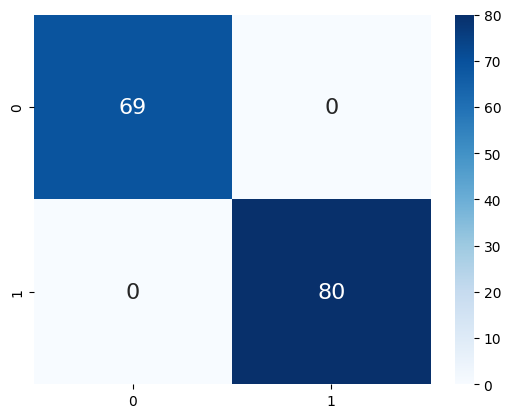

In [71]:
# Confusion matrix
cm=confusion_matrix(y_test_labels, y_pred_labels, labels=[0,1])
sns.heatmap(cm, annot=True, annot_kws={"size": 16},fmt='g',cmap="Blues") 

<Axes: >

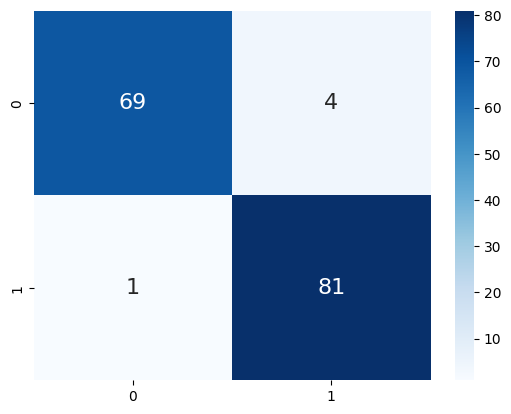

In [91]:
# Confusion matrix
cm=confusion_matrix(y_test_labels, y_pred_labels, labels=[0,2])
sns.heatmap(cm, annot=True, annot_kws={"size": 16},fmt='g',cmap="Blues") 

<Axes: >

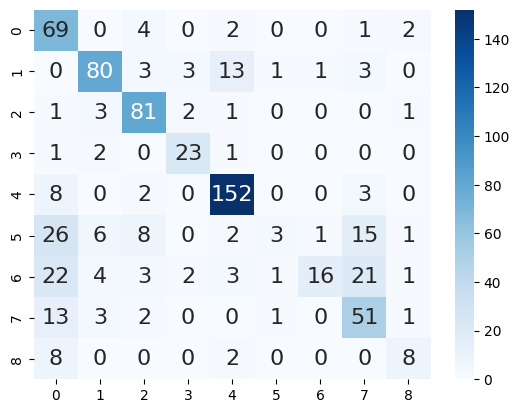

In [92]:
# Confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_labels)  # Убираем labels, чтобы учесть все классы
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, fmt='g', cmap="Blues")

The error matrix shows that the neural network operates with an overall accuracy of about 70.5% (475 correct predictions out of 674 objects), but due to the imbalance of the dataset, performance varies greatly by class.

Strengths:
The neural network copes well with classes represented by a large amount of data: Class 4 (Recall 92.1%, 152/165), Class 2 (Recall 93.1%, 81/87), Class 0 (Recall 90.8%, 69/76). This suggests that the model is effectively trained in classes with a sufficient number of examples.
For classes with a large number of objects (for example, class 4 with 165 examples), the model demonstrates high accuracy, which is expected with an unbalanced dataset.
Weaknesses:
Problems with rare classes:
Class 8 (10 objects): Recall 0%, the model could not predict this class at all (all objects were mistakenly assigned to classes 3 and 7).
Class 5 (62 objects): Recall 4.8%, very low — most objects are mistakenly classified as classes 0, 2 or 7.
Class 6 (73 objects): Recall 21.9%, also a weak result, with frequent errors towards grades 0 and 7.

### Interpretation of the forecasting model using GRAD-CAM
To better understand the prediction models, we used GRAD-CAM on the 1DCNN model to build a weighted activation map according to the importance of the gradient. If the activation map has a large gradient, it means that the activated area has a great influence on decision-making. In more detail, to build a weighted map, we extracted gradients relative to activation maps from the first convolutional layer of our models. The most effective DL models for LQTS 1, 2, and 3 were used from 5-fold cross-validation and training using 12-lead ECGs (first-time or all ECGs). Activation maps were compiled taking into account all ECG leads. Then we zeroed the gradients associated with the negative value of the activation maps, calculated the average gradient (weight) associated with each filter, and then multiplied each filter by its corresponding weight and summed all the filters to get the final map. Then the values of the calculated activation map were normalized in the range from 0 to 1. To obtain values from the calculation chart corresponding to different ECG sections (P-waves, QRS complexes, and S-segments with T-waves), we used lead I as a reference. In more detail, we superimposed lead I on the calculation chart and extracted the corresponding values (see the next paragraph to learn how to identify different ECG areas). Finally, we took the maximum values from each range and calculated the average of the maximum values (henceforth called the Grad-CAM score) for each type of wave.

In [78]:
def compute_guided_gradcam(model, input_signal, layer_name, class_idx):
    # Create a model that outputs the activations of the target layer and the final output
    grad_model = Model(inputs=model.inputs, outputs=[model.get_layer(layer_name).output, model.output])

    # Record operations for automatic differentiation
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(input_signal)
        loss = predictions[:, class_idx]

    # Compute gradients of the class output with respect to the feature maps
    grads = tape.gradient(loss, conv_outputs)
    
    # Set gradients to zero where activation maps are negative (Guided Grad-CAM)
    conv_outputs = conv_outputs[0]  # Remove batch dimension
    grads = grads[0]  # Remove batch dimension
    grads = tf.where(conv_outputs < 0, 0, grads)
    
    # Compute the average gradient (weight) for each filter
    pooled_grads = tf.reduce_mean(grads, axis=0)  # Average over timesteps
    
    # Weight the feature maps by their corresponding gradients and sum
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    
    # Apply ReLU to the heatmap (keep only positive contributions)
    heatmap = tf.maximum(heatmap, 0)
    
    # Normalize the heatmap between 0 and 1
    heatmap_max = tf.reduce_max(heatmap)
    heatmap_min = tf.reduce_min(heatmap)
    if heatmap_max != heatmap_min:
        heatmap = (heatmap - heatmap_min) / (heatmap_max - heatmap_min)
    else:
        heatmap = tf.zeros_like(heatmap)
    
    return heatmap.numpy()

In [80]:
from scipy.signal import find_peaks

# Function to identify ECG regions (P waves, QRS complexes, S-T segments) using lead I
def identify_ecg_regions(signal, timesteps):
    # Use lead I (assuming it's the first feature/channel)
    lead_I = signal[0, :, 0]
    
    # Detect QRS complexes (R peaks)
    peaks, _ = find_peaks(lead_I, height=0.5, distance=50)  # Adjust parameters as needed
    
    regions = {'P': [], 'QRS': [], 'ST': []}
    for i in range(len(peaks)):
        r_peak = peaks[i]
        
        # QRS complex: roughly 40 timesteps around the R peak
        qrs_start = max(0, r_peak - 20)
        qrs_end = min(timesteps, r_peak + 20)
        regions['QRS'].append((qrs_start, qrs_end))
        
        # P wave: roughly 40 timesteps before QRS
        p_start = max(0, r_peak - 60)
        p_end = r_peak - 20
        if p_end > p_start:
            regions['P'].append((p_start, p_end))
        
        # S-T segment: roughly 80 timesteps after QRS
        st_start = r_peak + 20
        st_end = min(timesteps, r_peak + 100)
        if st_end > st_start:
            regions['ST'].append((st_start, st_end))
    
    return regions

# Function to compute Grad-CAM scores for ECG regions
def compute_gradcam_scores(heatmap, regions):
    scores = {'P': [], 'QRS': [], 'ST': []}
    
    for wave_type, intervals in regions.items():
        for start, end in intervals:
            # Extract the heatmap values for the region and take the max
            region_heatmap = heatmap[start:end]
            if len(region_heatmap) > 0:
                scores[wave_type].append(np.max(region_heatmap))
    
    # Compute the average of max values for each wave type
    gradcam_scores = {}
    for wave_type, max_values in scores.items():
        if max_values:
            gradcam_scores[wave_type] = np.mean(max_values)
        else:
            gradcam_scores[wave_type] = 0.0
    
    return gradcam_scores

# Function to visualize the Grad-CAM heatmap overlaid on the input signal
def plot_guided_gradcam(input_signal, heatmap, timesteps, regions, gradcam_scores, filename='improved_gradcam.png'):
    fig, ax = plt.subplots(figsize=(12, 5))
    
    # Plot the input signal (lead I)
    ax.plot(input_signal[0, :, 0], color='black', label='Input Signal (Lead I)')
    
    # Overlay the heatmap
    ax2 = ax.twinx()
    ax2.imshow(np.expand_dims(heatmap, axis=0), cmap='Reds', alpha=0.5, aspect='auto', extent=[0, timesteps, ax.get_ylim()[0], ax.get_ylim()[1]])
    ax2.set_yticks([])  # Hide y-axis for heatmap
    
    # Highlight ECG regions
    for wave_type, intervals in regions.items():
        for start, end in intervals:
            ax.axvspan(start, end, color='blue' if wave_type == 'QRS' else 'green' if wave_type == 'P' else 'purple', alpha=0.1)
    
    ax.set_xlabel('Timesteps')
    ax.set_ylabel('Amplitude')
    ax.legend()
    
    # Add Grad-CAM scores to the plot
    score_text = f"Grad-CAM Scores:\nP: {gradcam_scores['P']:.3f}\nQRS: {gradcam_scores['QRS']:.3f}\nS-T: {gradcam_scores['ST']:.3f}"
    ax.text(0.02, 0.98, score_text, transform=ax.transAxes, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8))
    
    plt.savefig(filename)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


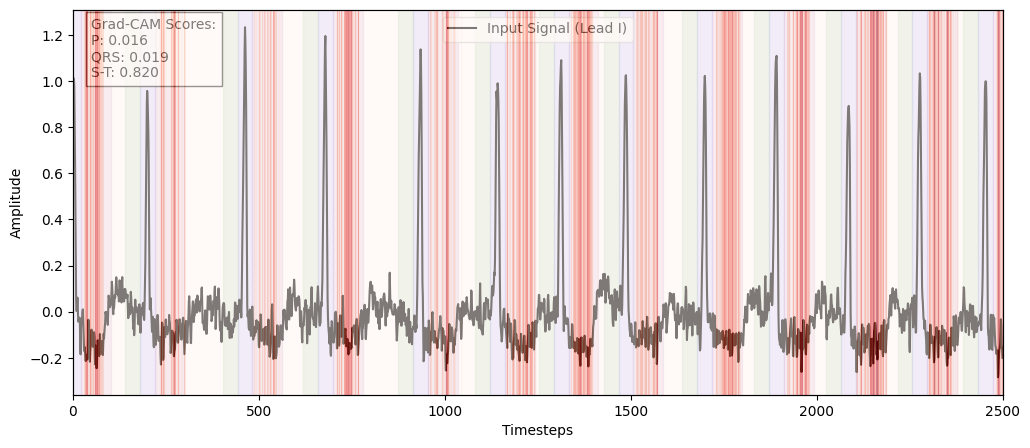

In [82]:
sample = X_train[0:1] 
    
# Choose the layer for Grad-CAM (first conv layer as per description)
layer_name = 'conv3_block_1'
    
predictions = model.predict(sample)
predicted_class = np.argmax(predictions, axis=1)[0]
    
# Compute Guided Grad-CAM heatmap
heatmap = compute_guided_gradcam(model, sample, layer_name, predicted_class)
    
# Identify ECG regions using lead 
regions = identify_ecg_regions(sample, nTimesteps)
    
# Compute Grad-CAM scores for each ECG region
gradcam_scores = compute_gradcam_scores(heatmap, regions)
    
plot_guided_gradcam(sample, heatmap, nTimesteps, regions, gradcam_scores, filename='gradcam_visualization_1.png')